# Analysis of the HRS data using VARGLLVM

We want to analyse the HRS data using the VARGLLVM model.



### Loading data
The data has been pre-processed as a 3D array with dimensions given by $(n, k+p, T)$.

The final array is a 3D array of shape (n, k+p, T), where 
* n is the number of observations, 
* k is the number of covariates,
* p is the number of responses to be modeled by the latent variables,
* T is the number of time observations

The variables are originally ordered as follows:

**Covariates**

- age (covariate)
- gender (covariate)
- education (covariate)

**Responses**

- month (binary)
- day (binary)
- year (binary)
- day_week (binary)
- paper (binary)
- cactus (binary)
- president (binary)
- vice_president (binary)
- serie_7 (count)
- backwards (ordinal)
- recall_immediate (count)
- recall_delayed (count)

The binary random variables are modelled conditionally with a logistic regression; the ordinal variables with an ordinal logistic regression; the counts with poisson regression.

The ordinal responses require an intercept for each level, or "cutpoints". In our case, we model this by hard-coding the intercept, but it should be made more general. We assume the effect of the covariates is constant across categories, resulting in a proportional odds model.

Since the ordinal variable has only 3 categories (0,1,2) and that 2 has very few non-zero elements, we will merge categories 1 and 2 and consider it as a bernoulli random variable.

**Covariates**

- 0: age (covariate)
- 1: gender (covariate)
- 2: education (covariate)

**Responses**

- 0: month (binary)
- 1: day (binary)
- 2: year (binary)
- 3: day_week (binary)
- 4: paper (binary)
- 5: cactus (binary)
- 6: president (binary)
- 7: vice_president (binary)
- 8: serie_7 (count)
- 9: backwards (dummy)
- 10: recall_immediate (count)
- 11: recall_delayed (count)

Silvia said we should remove cactus and backwards.

In [1]:
import sys
sys.path.append("../../../VARGLLVM/")
import VARGLLVM
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR # scheduler
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import copy

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:500mb" # this ist to prevent cuda to reserve too much memory


# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Import the preprocessed data
data = np.load("../../../data/HRS/HRS_3Darray_innerjoin.npy")
data = data
print(data.shape)

CUDA is not available. Using CPU.
(6383, 15, 9)


In [2]:
names = [
    "age",
    "gender",
    "education",
    "month",
    "day",
    "year",
    "day_week",
    "paper",
    "cactus",
    "president",
    "vice_president",
    "serie_7",
    "backwards",
    "recall_immediate",
    "recall_delayed"
]

In [3]:
# for i in range(data.shape[1]):
#     # Get the data for this feature (flatten and filter out NaNs)
#     feature_data = data[:, i].flatten()
#     valid_data = feature_data[~np.isnan(feature_data)]  # filtering out NaN values

#     plt.figure(figsize=(10, 4))
#     plt.hist(valid_data, bins=30)
#     plt.title(f'Histogram for Feature {i}: {names[i]}')
#     plt.xlabel(f'Feature {i} Values')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

After discussing problems with Silvia, we decided to remove paper and cactus from the datasets.


In [4]:
# Create the backwards dummy
data[:,12] = data[:,12]>=1

In [5]:
names[12]

'backwards'

In [6]:
# Transpose the data from (batch_length, num_features, seq_length) to  (batch_length, seq_length, num_features)
# Separate covariates and responses, and prepare the torch tensors
data = np.transpose(data, (0,2,1))

# SELECT ONLY FIRST 1000

# data = data[:1000,]
# Remove problematic variables

vars_to_remove = ["cactus", "paper"]  # in descending order
idx_to_remove = [names.index(var) for var in vars_to_remove]
idx_to_remove.sort(reverse=True)


In [7]:
[np.sum(np.isnan(data[:,:,i])) for i in range(data.shape[2])]

[0,
 0,
 288,
 20770,
 20770,
 20770,
 20770,
 20770,
 20770,
 20770,
 20770,
 1425,
 0,
 3242,
 3339]

In [8]:
np.sum(np.isnan(data)) / np.prod(data.shape)

0.20245211528307253

In [9]:
np.isnan(data[:,:,12])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

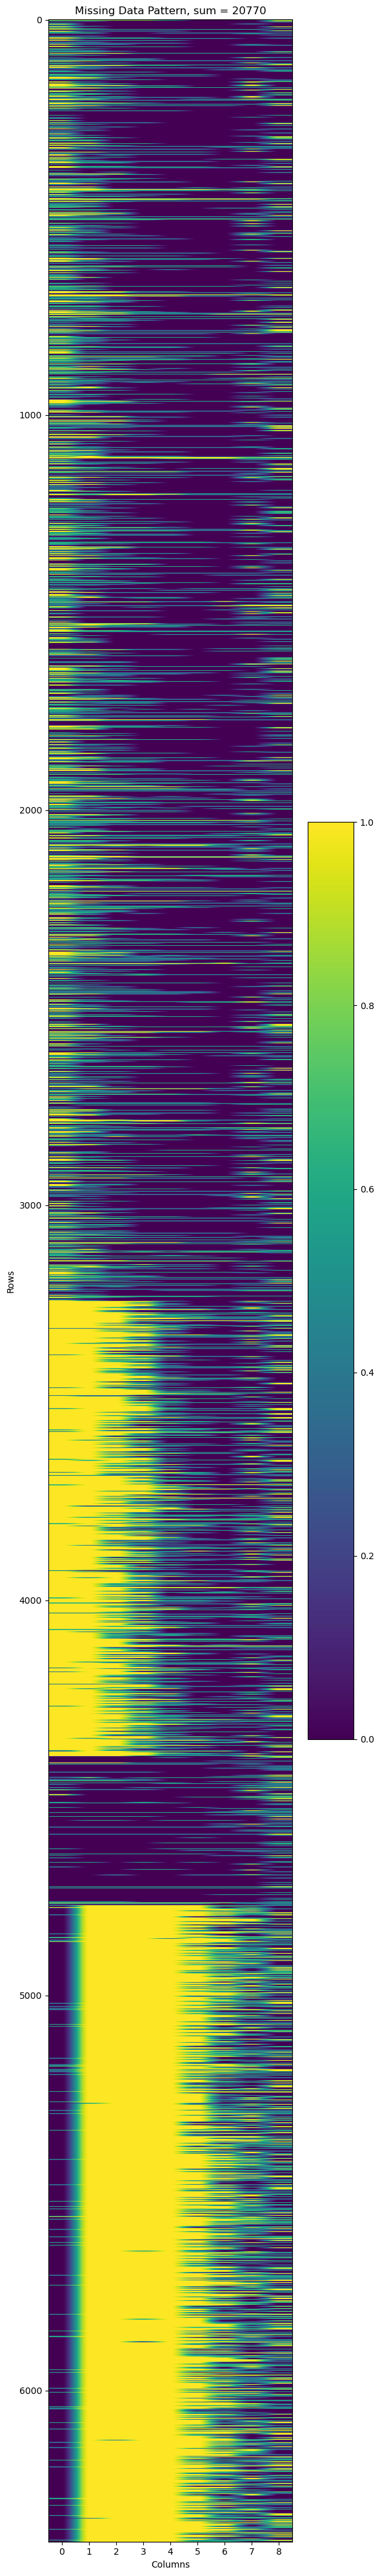

In [10]:
# Display the missing data pattern
i = 9
plt.figure(figsize=(6, 40))
plt.imshow(np.isnan(data[:,:,i]), cmap='viridis', aspect='auto')  # 'True' values will be shown in a distinct color
plt.colorbar()
plt.title(f'Missing Data Pattern, sum = {np.sum(np.isnan(data[:,:,i]))}')
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [11]:
for idx in idx_to_remove:
    data = np.delete(data, idx, axis=2)
    names.pop(idx)

# Create x and y variables
data_true = {
    'x': torch.from_numpy(data[:,:,:3]).float(), # TODO TAKE ALL ,, NOT FIRST 1000!
    'y': torch.from_numpy(data[:,:,3:]).float()
}

data_true['mask'] = torch.isnan(data_true['y'])

# impute x with the mean across time:

import torch
import numpy as np

# Assuming you've already set up data_true as in your provided code

# Create a mask for 'x'
mask_x = torch.isnan(data_true['x'])

# Step 1: Calculate the per-person average over time for non-NaN values
per_person_avg = torch.nanmean(data_true['x'], dim=1, keepdim=True)

# Step 2: Replace NaN values in 'x' using the per-person average
data_true['x'] = torch.where(mask_x, per_person_avg, data_true['x'])

# Check if there are still NaN values
if torch.isnan(data_true['x']).sum() > 0:
    # Step 3: Replace remaining NaNs with the overall average of 'x'
    overall_avg = torch.nanmean(data_true['x'])
    data_true['x'] = torch.where(torch.isnan(data_true['x']), overall_avg, data_true['x'])

# Verify if there are any missing values left
assert torch.isnan(data_true['x']).sum() == 0, "There are still NaN values!"



In [12]:
# for i in range(data.shape[2]):
#     # Get the data for this feature (flatten and filter out NaNs)
#     feature_data = data[:,:, i].flatten()
#     valid_data = feature_data[~np.isnan(feature_data)]  # filtering out NaN values

#     plt.figure(figsize=(10, 4))
#     plt.hist(valid_data, bins=30)
#     plt.title(f'Histogram for Feature {i}: {names[i]}')
#     plt.xlabel(f'Feature {i} Values')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

In [13]:
for i, z in zip(names, range(len(names))):
    print(f'{z-3} : {i}')

-3 : age
-2 : gender
-1 : education
0 : month
1 : day
2 : year
3 : day_week
4 : president
5 : vice_president
6 : serie_7
7 : backwards
8 : recall_immediate
9 : recall_delayed


In [14]:



response_types = {
    'bernoulli': [0, 1, 2, 3, 4, 5, 7],
    'poisson': [6, 8, 9]
}


# only the poisson
data_true['y'] = data_true['y'][:,:, [6,8,9]]
data_true['mask'] = data_true['mask'][:,:, [6,8,9]]
response_types = {
    'poisson': [0,1,2]
}

batch_size = data_true['y'].shape[0]
num_var = data_true['y'].shape[2]
seq_length = data_true['y'].shape[1]
num_covar = data_true['x'].shape[2]

num_latent = 1


In [15]:
# Model Creation
# --------------
model = VARGLLVM.VARGLLVM(num_var = num_var,
                 num_latent = num_latent,
                 num_covar = num_covar,
                 response_types = response_types,
                 add_intercepts=True,
                 fixed_first_loading = False,
                 VAR1_intercept=True,
                 VAR1_slope =True)

# model.load_state_dict(torch.load('model1_onlypoisson.pth'))

encoder = VARGLLVM.Encoder(num_var, num_covar, num_latent, num_hidden=10)

In [16]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the models to device
# Move the models and data to device
encoder = encoder.to(device)
model = model.to(device)
data_true = {key:value.to(device) for key, value in data_true.items()} # Moving data to the device
# initial imputation
data_true['y'] = VARGLLVM.impute_values(model=None, encoder=None, y=data_true['y'], mask=data_true['mask'], x=data_true['x'], impute_with=0.5)


In [22]:

# Define optimizer and criterion as before
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
encoder_criterion = nn.MSELoss()

model_optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model_criterion = VARGLLVM.MELoss()

# Define schedulers
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.8)
model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=0.8)


In [18]:

all_params = []


In [26]:
for ii in range(10):
    # Reset the learning rate for each parameter group
    for param_group in encoder_optimizer.param_groups:
        param_group['lr'] = 0.01

    for param_group in model_optimizer.param_groups:
        param_group['lr'] = 0.2

    # Reset the schedulers
    encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.8)
    model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=1.)

    # Define schedulers

    impute_with = None # None to impute with the conditional mean 
    
    if ii==9:
        i_max = 200
    else:
        i_max = 100
    for i in range(i_max):
        with torch.no_grad():
            data_true['y'] = VARGLLVM.impute_values(model, encoder, data_true['y'], data_true['mask'], data_true['x'], impute_with = impute_with)
            
        encoder_loss = VARGLLVM.train_encoder(
            encoder, 
            model, 
            encoder_criterion, 
            encoder_optimizer, 
            num_epochs=1, 
            sample=True,
            batch_size=data_true['x'].shape[0],
            seq_length=data_true['x'].shape[1],
            x=data_true['x'],
            data=None,  
            verbose=False,
            mask=data_true['mask'], # None if the encoder should learn from complete data, the mask otherwise
            impute_with=impute_with)
        encoder_scheduler.step()  # Step the encoder scheduler
        
        decoder_loss = VARGLLVM.train_decoder(
            model, 
            encoder, 
            model_criterion, 
            model_optimizer, 
            data_true,
            num_epochs=1, 
            transform=True, # True to transform no grad the outcomes just before taking the loss
            verbose=False,
            mask = data_true['mask'],
            impute_with=impute_with)
        
        model_scheduler.step()  # Step the model scheduler

        with torch.no_grad():
            encoded_epsilon, encoded_u = encoder(y=data_true['y'], VARGLLVM_model=model, x=data_true['x'])
            _, decoded_mean = model(encoded_epsilon, encoded_u, data_true['x'])
            loss = torch.mean(torch.pow(decoded_mean[~data_true['mask']] - data_true['y'][~data_true['mask']],2))
        
        print(f'var_u: {torch.exp(model.logvar_u)}')
        print(f'Iteration {ii}:{i}: encoder loss {encoder_loss}, decodeur: {decoder_loss}, overall: {loss.detach().numpy()}')
        all_params.append(copy.deepcopy(model.state_dict()))


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

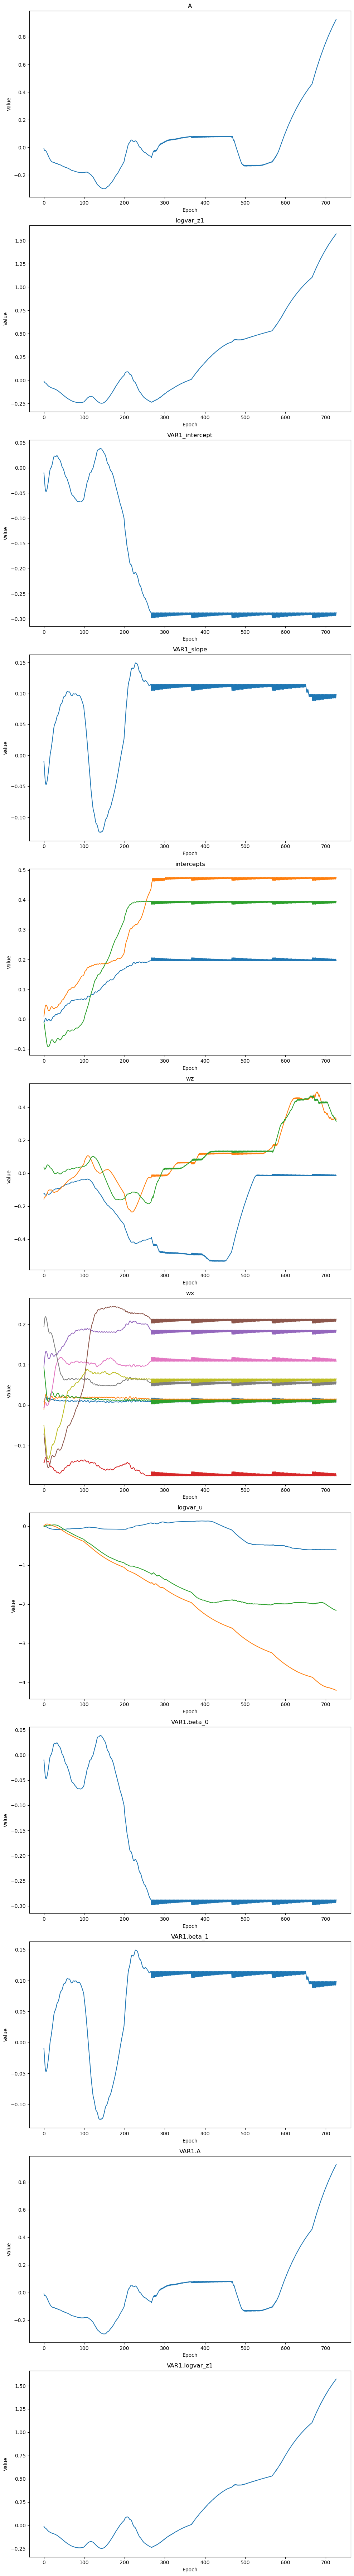

In [24]:

def plot_param_evolution(all_params):
    """
    Plot the evolution of model parameters across epochs.

    Parameters:
    - all_params (list): A list containing the state_dict of the model for each epoch.

    Returns:
    - None
    """

    # Convert model parameters to a format suitable for plotting
    param_timeseries = {}

    for epoch_params in all_params:
        for param_name, param_value in epoch_params.items():
            param_flat = param_value.cpu().numpy().flatten()  # flatten the tensor
            
            if param_name not in param_timeseries:
                param_timeseries[param_name] = []
            
            param_timeseries[param_name].append(param_flat)

    # Plot each parameter's evolution over epochs
    num_params = len(param_timeseries)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 6 * num_params))

    for ax, (param_name, time_series) in zip(axes, param_timeseries.items()):
        time_series = np.array(time_series)
        
        for i in range(time_series.shape[1]):
            ax.plot(time_series[:, i], label=f"Element {i}")
            
        ax.set_title(param_name)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        # ax.legend()  # Uncomment if you want a legend for each flattened element

    plt.tight_layout()
    plt.show()

plot_param_evolution(all_params)

In [ ]:
encoded_epsilon, encoded_u = encoder(y=data_true['y'], VARGLLVM_model=model, x=data_true['x'])
_, decoded_mean = model(encoded_epsilon, encoded_u, data_true['x'])

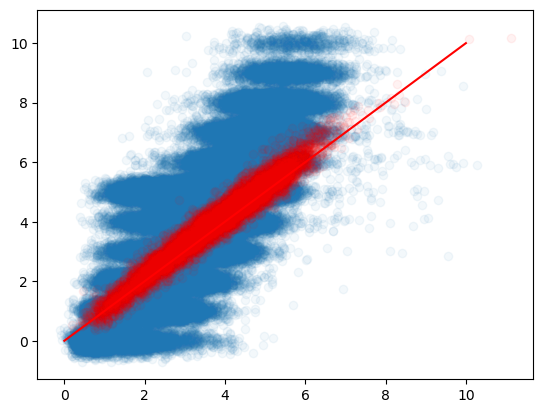

In [ ]:

def add_jitter(arr, scale=0.2):
    return arr + np.random.randn(*arr.shape) * scale

# Extract data
x_without_mask = decoded_mean[~data_true['mask']].detach().numpy()
y_without_mask = data_true['y'][~data_true['mask']].detach().numpy()
x_with_mask = decoded_mean[data_true['mask']].detach().numpy()
y_with_mask = data_true['y'][data_true['mask']].detach().numpy()

# Apply jitter
x_without_mask_jittered = add_jitter(x_without_mask)
y_without_mask_jittered = add_jitter(y_without_mask)
x_with_mask_jittered = add_jitter(x_with_mask)
y_with_mask_jittered = add_jitter(y_with_mask)

# Scatter plot with jitter and alpha transparency
plt.scatter(x_without_mask_jittered, y_without_mask_jittered, alpha=0.05)
plt.scatter(x_with_mask_jittered, y_with_mask_jittered, color="red", alpha=0.05)
plt.plot([0,10],[0,10], color="red")

plt.show()

Text(0.5, 1.0, 'Evolution of latent variables over time for the first 1000 respondents.')

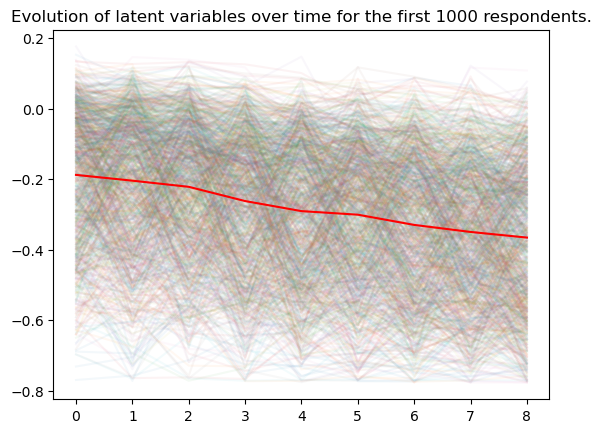

In [ ]:
plt.plot(model.VAR1(encoded_epsilon)[:1000,:,0].detach().T, alpha=.05)
plt.plot(torch.mean(model.VAR1(encoded_epsilon)[:1000,:,0].detach().T, dim=1).unsqueeze(1), color="red")
plt.title("Evolution of latent variables over time for the first 1000 respondents.")

In [ ]:
torch.mean(model.VAR1(encoded_epsilon)[:1000,:,0].detach().T, dim=1).shape

torch.Size([9])

In [ ]:
torch.var(encoded_epsilon)

tensor(0.1603, grad_fn=<VarBackward0>)

In [ ]:
1/torch.exp(model.logvar_z1)

tensor([0.1130], grad_fn=<MulBackward0>)

In [ ]:
torch.save(model.state_dict(), 'model1_onlypoisson.pth')
